In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import torch as th
import torch.nn as nn
from torch import optim
import os
import torch.nn.functional as F
import matplotlib.pyplot as plt
from copy import deepcopy
%matplotlib inline

/opt/conda/envs/ibmaml/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.environ['DGLBACKEND'] = 'pytorch'
import dgl
from dgl import function as fn

In [3]:
dgl_version = f"dgl-cu{th.version.cuda.replace('.', '')}==0.7.2"
dgl_version

'dgl-cu116==0.7.2'

In [4]:
device = th.device('cuda' if th.cuda.is_available() else 'cpu')
device

device(type='cuda')

The original data set has about 46 million transactions. To get a good sense and be a fast to run example, lowering to 1 million would be good. In the dataset there are different currency, but I don't think in this example we will use it so I will only take US dollars

In [5]:
#data=pd.read_csv("trans_3000p2_list.txt", chunksize=1000000)

In [6]:
"""
i=0
new_data=pd.DataFrame()
for df in data:
    sample_df=df[df["Receiving Currency"]=="US Dollar"]
    sample_df=sample_df.sample(min(len(sample_df["Receiving Currency"]),20000))
    new_data=pd.concat([new_data,sample_df])
new_data.to_csv("sample_data.csv")
"""

'\ni=0\nnew_data=pd.DataFrame()\nfor df in data:\n    sample_df=df[df["Receiving Currency"]=="US Dollar"]\n    sample_df=sample_df.sample(min(len(sample_df["Receiving Currency"]),20000))\n    new_data=pd.concat([new_data,sample_df])\nnew_data.to_csv("sample_data.csv")\n'

In [7]:
df=pd.read_csv("sample_data.csv")

/opt/conda/envs/ibmaml/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3369: DtypeWarning: Columns (6) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [8]:
df=df.rename(columns={"Unnamed: 0":"ID"})

In [9]:
df.loc[df['Amount Received']=='(null)', 'Amount Received']=0
df.loc[df['Amount Paid']=='(null)', 'Amount Paid']=0

In [10]:
df["dataset"]=np.concatenate([np.zeros(650000), np.ones(151050)])

In [11]:
df

,ID,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,dataset
0,597486,2019/01/01 22:31,80010C840,864F01E50,8124400A0,8339CA5D0,6049.78,US Dollar,6049.78,US Dollar,ACH,0,0.0
1,433457,2019/01/01 08:10,8204C00E0,8C94D9EE0,8AEC7DFD0,8C94DB050,1013.97,US Dollar,1013.97,US Dollar,ACH,0,0.0
2,125115,2019/01/01 00:01,9D564FF90,B293D63B0,94CAFB7C0,951746F30,1503.76,US Dollar,1503.76,US Dollar,Credit Card,0,0.0
3,124612,2019/01/01 00:17,9FCF0F230,B25E87670,8687C23B0,88E7D86A0,36.62,US Dollar,36.62,US Dollar,Credit Card,0,0.0
4,471821,2019/01/01 11:52,8035BE0B0,807196E40,800B44D80,80716A2E0,1706.78,US Dollar,1706.78,US Dollar,ACH,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
801045,45380265,2019/01/31 22:16,911E77470,94ED31420,98EB028E0,AEB849BA0,8384.22,US Dollar,8384.22,US Dollar,Cheque,0,1.0
801046,45175273,2019/01/31 09:08,86F3F8860,90533C030,807E63B90,90533C170,464.98,US Dollar,464.98,US Dollar,ACH,0,1.0
801047,45175159,2019/01/31 09:15,829065E90,8EB7D9E90,8CE4C4470,8EB7BE480,3597.80,US Dollar,3597.80,US Dollar,ACH,0,1.0
801048,45012172,2019/01/31 01:37,88128D3F0,8AEDE5B60,84E9B9E40,8AEDE3DA0,963.23,US Dollar,963.23,US Dollar,ACH,0,1.0


Lets generate the nodes related to these transactions

In [12]:
def column_index(series, offset=0):
    return {k: v+offset for v, k in enumerate(series.value_counts().index.values)}

In [13]:
txn2idx = {v: idx for idx, v in enumerate(df['ID'].values)}
acct2idx = column_index(pd.concat([df['Account'],df["Account.1"]]))
bank2idx = column_index(pd.concat([df['From Bank'],df["To Bank"]]))

In [14]:
df['txnIdx'] = df['ID'].map(txn2idx)
df = df.sort_values(by='txnIdx')
df['acct1Idx'] = df['Account'].map(acct2idx)
df['acct2Idx'] = df['Account.1'].map(acct2idx)
df['dbankIdx'] = df['From Bank'].map(bank2idx) #d for debit
df['cbankIdx'] = df['To Bank'].map(bank2idx) #c for credit

In [15]:
df

,ID,Timestamp,From Bank,Account,To Bank,Account.1,Amount Received,Receiving Currency,Amount Paid,Payment Currency,Payment Format,Is Laundering,dataset,txnIdx,acct1Idx,acct2Idx,dbankIdx,cbankIdx
0,597486,2019/01/01 22:31,80010C840,864F01E50,8124400A0,8339CA5D0,6049.78,US Dollar,6049.78,US Dollar,ACH,0,0.0,0,673554,878735,6,544
1,433457,2019/01/01 08:10,8204C00E0,8C94D9EE0,8AEC7DFD0,8C94DB050,1013.97,US Dollar,1013.97,US Dollar,ACH,0,0.0,1,281873,221287,740,4740
2,125115,2019/01/01 00:01,9D564FF90,B293D63B0,94CAFB7C0,951746F30,1503.76,US Dollar,1503.76,US Dollar,Credit Card,0,0.0,2,4560,221286,7753,5718
3,124612,2019/01/01 00:17,9FCF0F230,B25E87670,8687C23B0,88E7D86A0,36.62,US Dollar,36.62,US Dollar,Credit Card,0,0.0,3,90592,221285,9359,1994
4,471821,2019/01/01 11:52,8035BE0B0,807196E40,800B44D80,80716A2E0,1706.78,US Dollar,1706.78,US Dollar,ACH,0,0.0,4,796671,545,67,29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801045,45380265,2019/01/31 22:16,911E77470,94ED31420,98EB028E0,AEB849BA0,8384.22,US Dollar,8384.22,US Dollar,Cheque,0,1.0,801045,224968,337043,4700,7764
801046,45175273,2019/01/31 09:08,86F3F8860,90533C030,807E63B90,90533C170,464.98,US Dollar,464.98,US Dollar,ACH,0,1.0,801046,878732,1042909,2385,153
801047,45175159,2019/01/31 09:15,829065E90,8EB7D9E90,8CE4C4470,8EB7BE480,3597.80,US Dollar,3597.80,US Dollar,ACH,0,1.0,801047,878733,193,924,4721
801048,45012172,2019/01/31 01:37,88128D3F0,8AEDE5B60,84E9B9E40,8AEDE3DA0,963.23,US Dollar,963.23,US Dollar,ACH,0,1.0,801048,337421,188,4202,1357


In [16]:
y_txn=df["Is Laundering"].values
baseline=y_txn[df['dataset']==0].mean()

In [17]:
node_id_cols = ['txnIdx', 'acct1Idx', 'acct2Idx']

In [18]:
N_nodes = df[node_id_cols].nunique().sum()
N_nodes

2024544

Lets generate the edges now that we have all the vertices

In [19]:
from itertools import combinations

In [20]:
edge_dict = dict()
for src_type, dst_type in combinations(node_id_cols, 2):
    fwd = (src_type, f'{src_type}-{dst_type}', dst_type)
    bwd = (dst_type, f'{dst_type}-{src_type}', src_type)
    
    edges = df[[src_type, dst_type]].drop_duplicates().values
    src = edges[:,0]
    dst = edges[:,1]

    edge_dict[fwd] = (th.tensor(src), th.tensor(dst))
    edge_dict[bwd] = (th.tensor(dst), th.tensor(src))


In [21]:
edge_dict

{('txnIdx',
  'txnIdx-acct1Idx',
  'acct1Idx'): (tensor([     0,      1,      2,  ..., 801047, 801048, 801049]), tensor([673554, 281873,   4560,  ..., 878733, 337421, 878734])),
 ('acct1Idx',
  'acct1Idx-txnIdx',
  'txnIdx'): (tensor([673554, 281873,   4560,  ..., 878733, 337421, 878734]), tensor([     0,      1,      2,  ..., 801047, 801048, 801049])),
 ('txnIdx',
  'txnIdx-acct2Idx',
  'acct2Idx'): (tensor([     0,      1,      2,  ..., 801047, 801048, 801049]), tensor([878735, 221287, 221286,  ...,    193,    188, 337032])),
 ('acct2Idx',
  'acct2Idx-txnIdx',
  'txnIdx'): (tensor([878735, 221287, 221286,  ...,    193,    188, 337032]), tensor([     0,      1,      2,  ..., 801047, 801048, 801049])),
 ('acct1Idx',
  'acct1Idx-acct2Idx',
  'acct2Idx'): (tensor([673554, 281873,   4560,  ..., 878733, 337421, 878734]), tensor([878735, 221287, 221286,  ...,    193,    188, 337032])),
 ('acct2Idx',
  'acct2Idx-acct1Idx',
  'acct1Idx'): (tensor([878735, 221287, 221286,  ...,    193,    188,

In [22]:
hg = dgl.heterograph(edge_dict)

In [23]:
label_feat = dict()
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        continue
    label_feat[ntype] = th.zeros(hg.number_of_nodes(ntype))+baseline
label_feat['txnIdx'] = th.tensor(np.nan_to_num(y_txn, nan=baseline)).float()

In [24]:
hg.ndata['label'] = label_feat

In [25]:
hg.ntypes

['acct1Idx', 'acct2Idx', 'txnIdx']

In [26]:
hg.ndata

defaultdict(<class 'dict'>, {'label': {'acct1Idx': tensor([0.0007, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007]), 'acct2Idx': tensor([0.0007, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007]), 'txnIdx': tensor([0., 0., 0.,  ..., 0., 0., 0.])}})

In [27]:
assert hg.number_of_nodes('txnIdx')==y_txn.shape[0]
assert (df['Is Laundering']==1).sum() == (dgl.to_homogeneous(hg, ndata=['label']).ndata['label']==1).sum().item()

In [28]:
import networkx as nx

In [29]:
def draw_kkl_hg(hg, **kwargs):
    
    hg_label = hg.ndata['label']['txnIdx'].int()
    
    g = dgl.to_homogeneous(hg)
    g.ndata['ntype'] = g.ndata['_TYPE']
    nx_G = g.to_networkx(node_attrs=['ntype']).to_undirected()
    fig, ax = plt.subplots(figsize=(10,10))
    
    pos = nx.spring_layout(nx_G, k=5/np.sqrt(g.num_nodes()))
    
    nodeShapes = ["^", "s", "o", "v"]
    # For each node class...
    for idx, ntype in enumerate(hg.ntypes):
        aShape = nodeShapes[idx]
        if ntype=='txnIdx':
            node_color = ['blue' if v==0 else 'red' if v==1 else 'black' for v in hg_label]
        else:
            node_color = "grey"
        nx.draw_networkx_nodes(
            nx_G, pos, node_shape=aShape, node_color=node_color, cmap='bwr', node_size=200,
            nodelist=[sNode[0] for sNode in filter(lambda x: x[1]["ntype"]==idx, nx_G.nodes(data=True))]
        )

    # Draw the edges between the nodes
    nx.draw_networkx_edges(nx_G, pos)

def plot_neighborhood(dataloader, N_plots=5):
    nstats = dict()
    for i, (input_nodes, output_nodes, blocks) in enumerate(dataloader):
        if i >= N_plots:
            break
        hg_tmp = dgl.node_subgraph(hg, input_nodes)
        draw_kkl_hg(hg_tmp)     
        

def neighborhood_stats(hg):
    def mp_fn_dict(in_feat, out_feat):
        return {
            cetype: (fn.copy_u(in_feat, 'm'), fn.sum('m', out_feat))
            for cetype in hg.canonical_etypes
        }
    
    with hg.local_scope():
        degree_data = dict()
        for ntype in hg.ntypes:
            in_degrees = th.zeros(hg.num_nodes(ntype))
            for cetype in hg.canonical_etypes:
                if cetype[2]==ntype:
#                     print(cetype)
                    in_degrees += hg.in_degrees(etype=cetype)
            degree_data[ntype] = in_degrees

        hg.ndata['degree'] = degree_data
        hg.ndata['N_ml'] = {
            ntype: (labels==1).float() for ntype, labels in hg.ndata['label'].items()
        }
        
        hg.multi_update_all(mp_fn_dict('degree', 'd_sum'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('N_ml', 'total_ml'), cross_reducer='sum')
        hg.multi_update_all(mp_fn_dict('total_ml', 'total_ml_2hop'), cross_reducer='sum')
        
        n_2hop = hg.ndata['d_sum']['txnIdx']
        ml_rate_2hop = hg.ndata['total_ml_2hop']['txnIdx'] / hg.ndata['d_sum']['txnIdx']
    return n_2hop, ml_rate_2hop

In [30]:
n_hops = 3
sampler = dgl.dataloading.MultiLayerNeighborSampler([10]*n_hops)

In [31]:
from dgl.dataloading import NodeDataLoader

In [32]:
dataloader_legit = NodeDataLoader(
    hg, {'txnIdx': np.where(y_txn==0)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

/opt/conda/envs/ibmaml/lib/python3.8/site-packages/dgl/dataloading/dataloader.py:859: DGLWarning: Dataloader CPU affinity opt is not enabled, consider switching it on (see enable_cpu_affinity() or CPU best practices for DGL [https://docs.dgl.ai/tutorials/cpu/cpu_best_practises.html])
  dgl_warning(f'Dataloader CPU affinity opt is not enabled, consider switching it on '


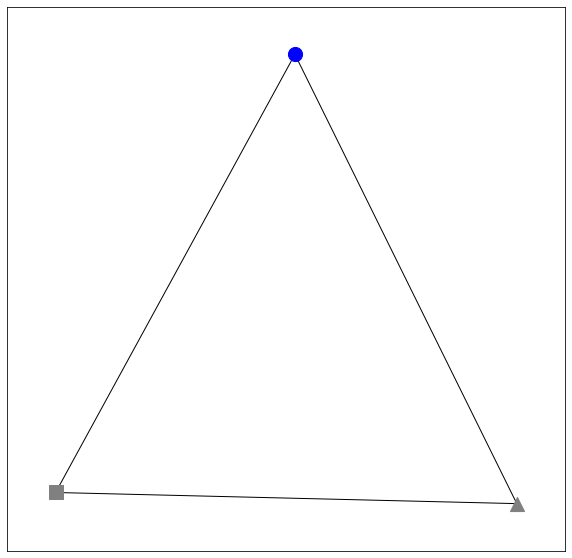

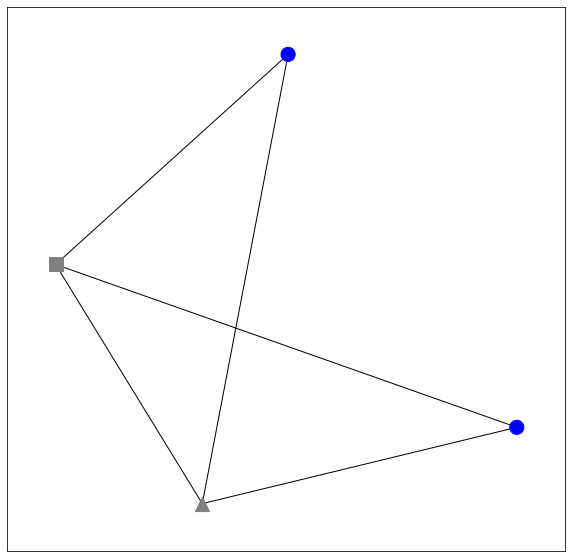

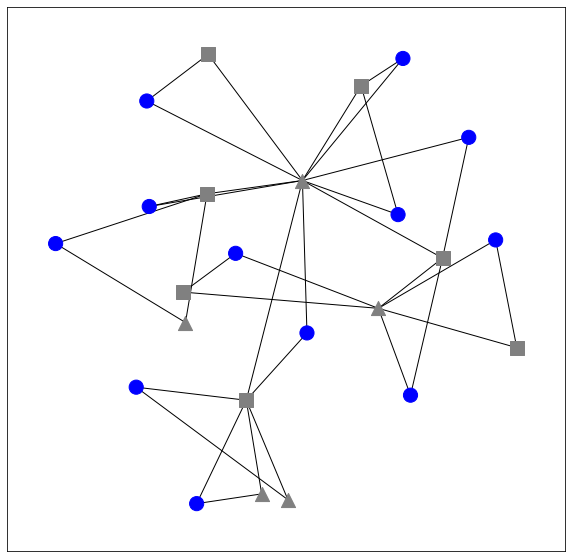

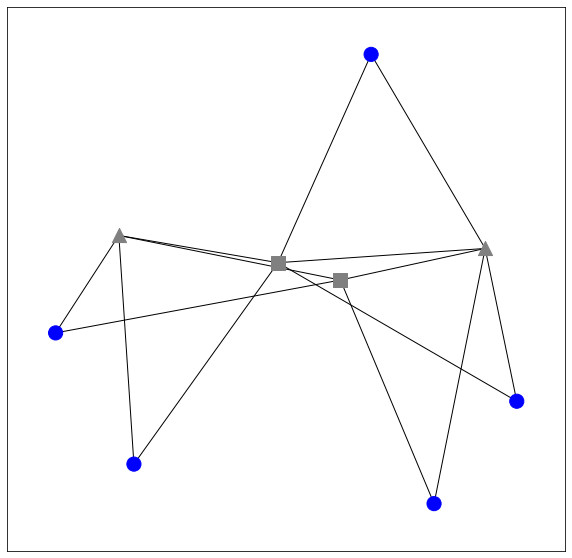

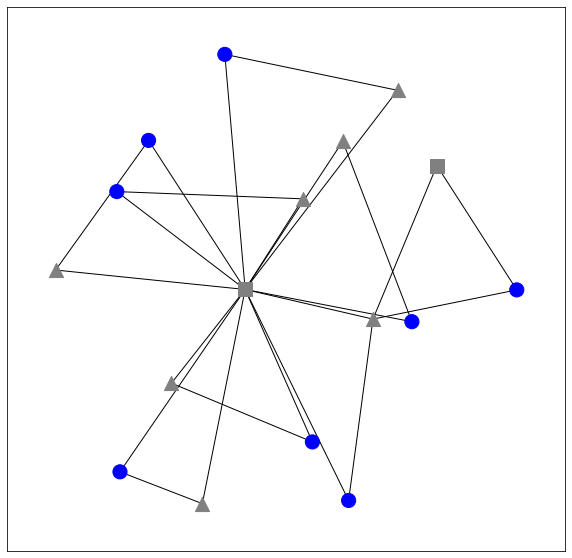

In [33]:
plot_neighborhood(dataloader_legit, N_plots=5)

In [34]:
dataloader_fraud = NodeDataLoader(
    hg, {'txnIdx': np.where(y_txn==1)[0]}, sampler,
    batch_size=1, shuffle=False, drop_last=False, num_workers=0)

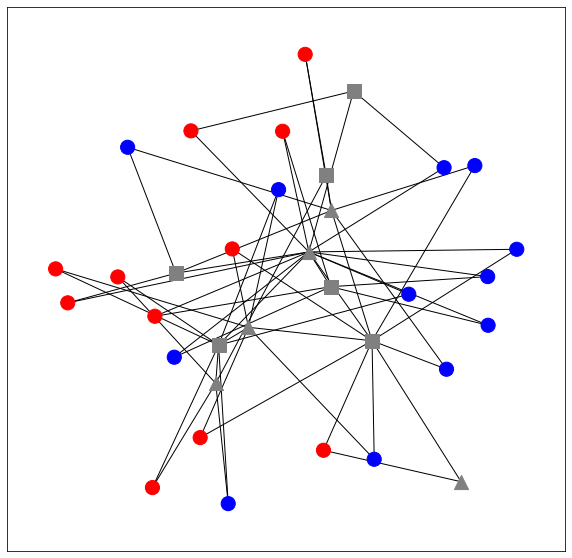

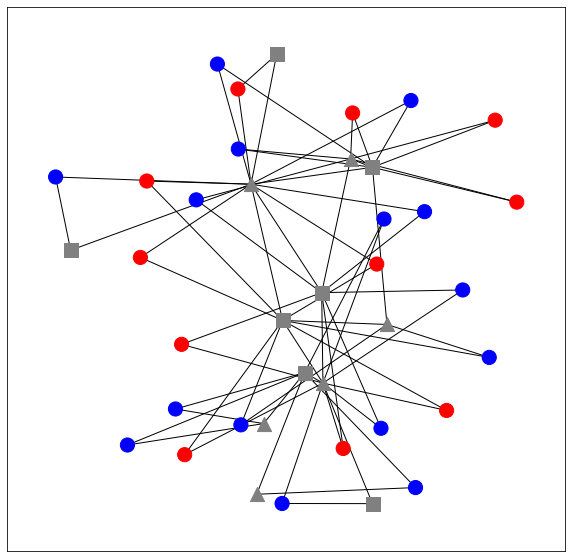

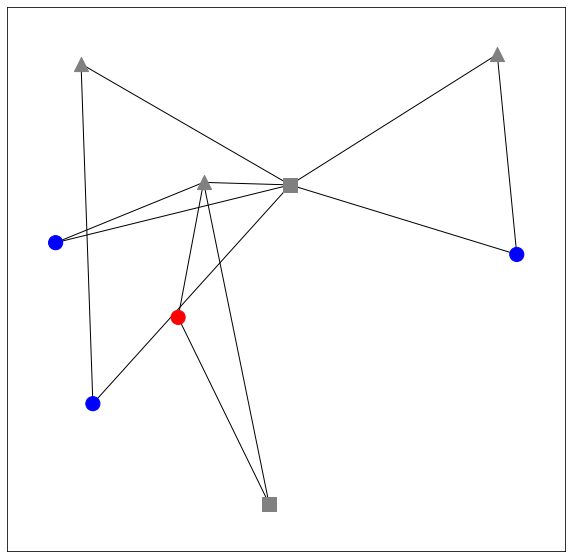

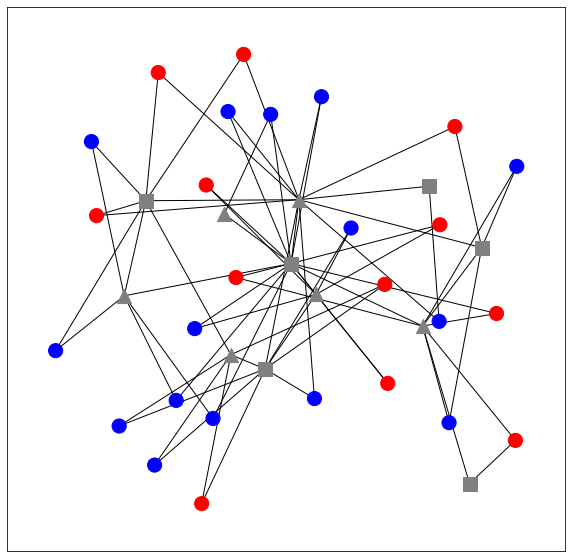

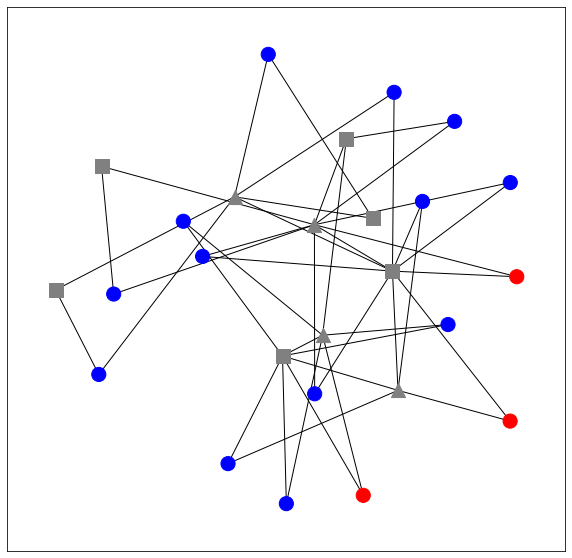

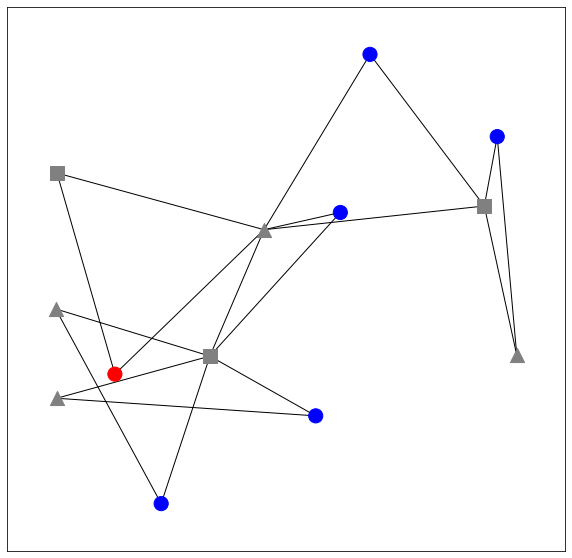

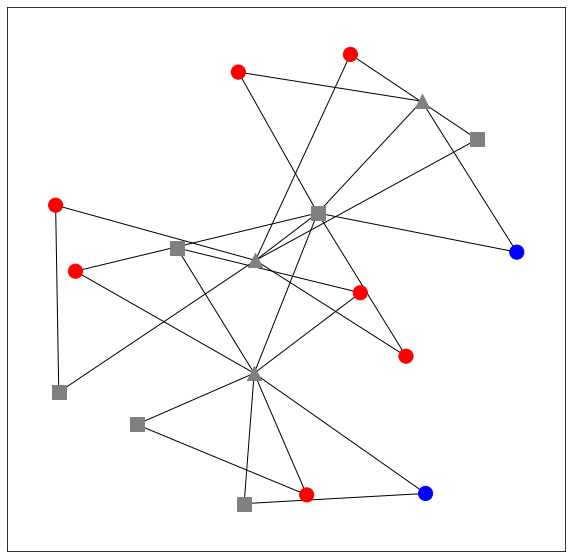

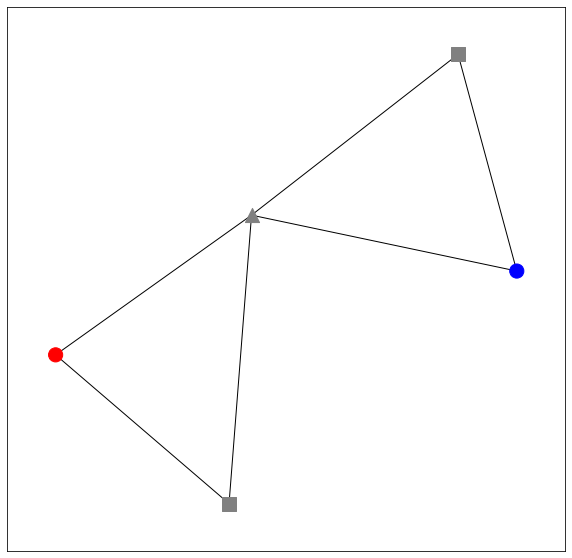

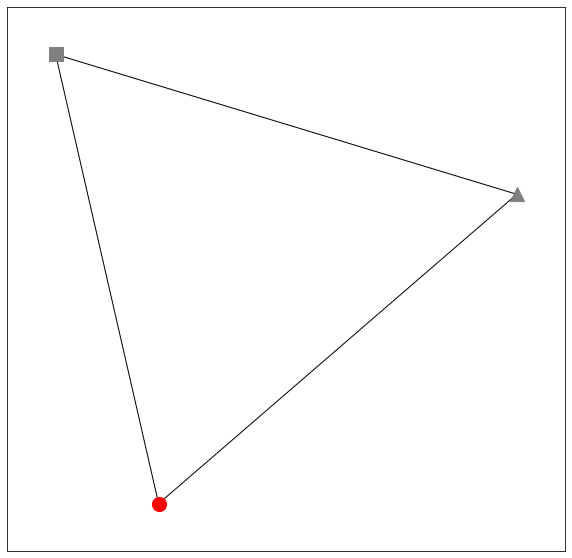

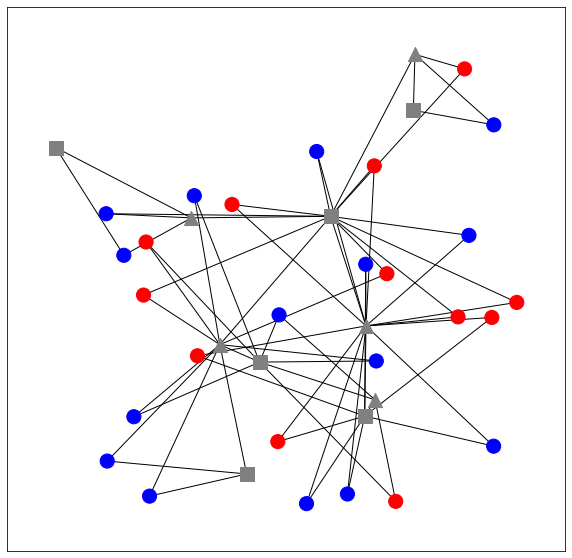

In [35]:
plot_neighborhood(dataloader_fraud, N_plots=10)

In [36]:
n_3hop, ml_rate_3hop = neighborhood_stats(hg)

In [37]:
N_labels = df[df['dataset']==0].shape[0]

In [38]:
df_nstats = pd.DataFrame({
    'N_2hop': n_3hop[:N_labels], 
    'ml_rate_3hop': ml_rate_3hop[:N_labels], 
    'label': y_txn[:N_labels],
})

In [39]:
df_nstats.groupby('label').describe().T

label                           0           1
N_2hop       count  649522.000000  478.000000
             mean        6.790301   54.085773
             std         4.773656  107.562149
             min         4.000000    4.000000
             25%         4.000000    4.000000
             50%         6.000000    7.000000
             75%         8.000000   18.000000
             max       316.000000  317.000000
ml_rate_3hop count  649522.000000  478.000000
             mean        0.000132    0.364754
             std         0.005229    0.130927
             min         0.000000    0.050000
             25%         0.000000    0.250000
             50%         0.000000    0.333333
             75%         0.000000    0.500000
             max         0.600000    0.700000

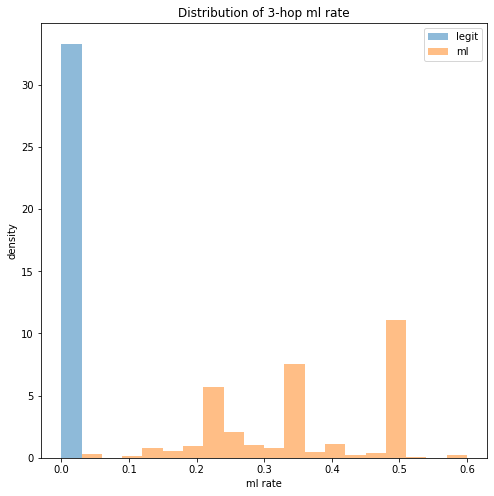

In [40]:
fig, ax = plt.subplots(figsize=(8,8))
_, bins, _ = ax.hist(df_nstats[df_nstats['label']==0]['ml_rate_3hop'], bins=20, alpha=0.5, density=True, label='legit')
_ = ax.hist(df_nstats[df_nstats['label']==1]['ml_rate_3hop'], bins=bins, alpha=0.5, density=True, label='ml')
ax.set(xlabel='ml rate', ylabel='density', 
       title=f'Distribution of {n_hops}-hop ml rate')
_ = ax.legend()

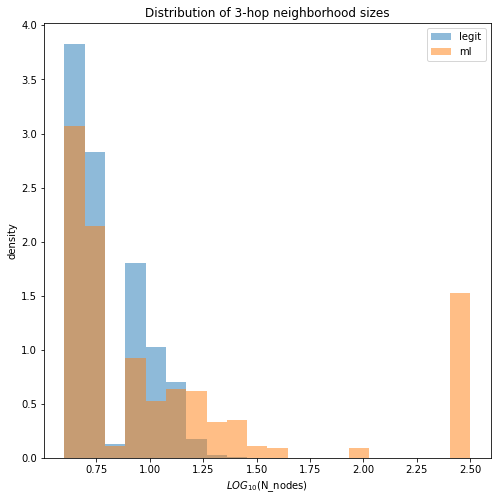

In [41]:
fig, ax = plt.subplots(figsize=(8,8))
_, bins, _ = ax.hist(
    np.log10(df_nstats[df_nstats['label']==0]['N_2hop']), bins=20, alpha=0.5, density=True, label='legit'
)
_ = ax.hist(
    np.log10(df_nstats[df_nstats['label']==1]['N_2hop']), bins=bins, alpha=0.5, density=True, label='ml'
)
ax.set(xlabel='$LOG_{10}($N_nodes$)$', ylabel='density', 
       title=f'Distribution of {n_hops}-hop neighborhood sizes')
_ = ax.legend()

In [42]:
df.nunique().sort_values(ascending=False)

ID                    801050
txnIdx                801050
Account.1             621429
acct2Idx              621429
Account               602065
acct1Idx              602065
Amount Received       390994
Amount Paid           330476
Timestamp              44054
From Bank              31463
dbankIdx               31463
cbankIdx               24869
To Bank                24869
Payment Currency          15
Payment Format             7
dataset                    2
Is Laundering              2
Receiving Currency         1
dtype: int64

In [43]:
categorical = ['Payment Currency', 'Payment Format']

In [214]:
pd.get_dummies(df[df['Amount Received']!='(null)'][categorical].astype(str), drop_first=True)

,Payment Currency_Bitcoin,Payment Currency_Brazil Real,Payment Currency_Canadian Dollar,Payment Currency_Euro,Payment Currency_Mexican Peso,Payment Currency_Ruble,Payment Currency_Rupee,Payment Currency_Saudi Riyal,Payment Currency_Shekel,Payment Currency_Swiss Franc,Payment Currency_UK Pound,Payment Currency_US Dollar,Payment Currency_Yen,Payment Currency_Yuan,Payment Format_Bitcoin,Payment Format_Cash,Payment Format_Cheque,Payment Format_Credit Card,Payment Format_Reinvestment,Payment Format_Wire
0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
801045,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0
801046,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
801047,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
801048,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0


In [44]:
X_ohe = pd.get_dummies(df[df['Amount Received']!='(null)'][categorical].astype(str), drop_first=True).values
X_amt = df[['Amount Received', 'Amount Paid']].astype(float).values

In [45]:
X_num = (X_amt - X_amt.mean(axis=0))/(X_amt.max(axis=0) - X_amt.min(axis=0))  #Normalize

In [46]:
X = np.concatenate([X_ohe, X_num], axis=1)

# Model Example

In [197]:
from sklearn.metrics import roc_auc_score, roc_curve, precision_recall_curve, f1_score, auc

In [203]:
def plot_roc(y_trues, y_preds, labels, x_max=1.0):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        fpr, tpr, thresholds = roc_curve(y_true, y_pred)
        auc = roc_auc_score(y_true, y_pred)
        ax.plot(fpr, tpr, label='%s; AUC=%.3f' % (labels[i], auc), marker='o', markersize=1)

    ax.legend()
    ax.grid()
    ax.plot(np.linspace(0, 1, 20), np.linspace(0, 1, 20), linestyle='--')
    ax.set_title('ROC curve')
    ax.set_xlabel('False Positive Rate')
    ax.set_xlim([-0.01, x_max])
    _ = ax.set_ylabel('True Positive Rate')
    
def plot_pr(y_trues, y_preds, labels):
    fig, ax = plt.subplots()
    for i, y_pred in enumerate(y_preds):
        y_true = y_trues[i]
        pr, re, thresholds = precision_recall_curve(y_true, y_pred)
        try:
            aucv = auc(re, pr)
            ax.plot(re, pr, label='%s; AUC=%.3f' % (labels[i], aucv), marker='o', markersize=1)
        except:
            pass
        f1_scores = 2*re*pr/(re+pr)
        print(labels[i])
        print('Best threshold: ', thresholds[np.argmax(f1_scores)])
        print('Best F1-Score: ', np.max(f1_scores))

    ax.legend()
    ax.grid()
    ax.set_title('Precision-Recall curve')
    ax.set_xlabel('Recall')
    _ = ax.set_ylabel('Precision')

In [49]:
baseline

0.0007353846153846154

In [50]:
# Indicies w/ labels (training data)
labeled_mask = np.zeros_like(y_txn, dtype=bool)
labeled_mask[:N_labels] = 1
assert y_txn[labeled_mask].mean()==baseline

In [51]:
# Split of training data into train/validation sets
rng = np.random.default_rng(1)
train_rate = 0.8
train_mask = (rng.random(y_txn.shape[0])>(1-train_rate))&labeled_mask
val_mask = ~train_mask&labeled_mask

In [52]:
test_mask = ~labeled_mask

In [53]:
# Laundering rate in train/val
y_txn[train_mask].mean(), y_txn[val_mask].mean()

(0.0007481891514496405, 0.0006842048616983655)

In [54]:
# Laundering count in train/val
y_txn[train_mask].sum(), y_txn[val_mask].sum()

(389, 89)

In [55]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

In [56]:
clf = LogisticRegression()
clf.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_lr = clf.predict_proba(X[val_mask,:])
y_val_lr = clf.predict(X[val_mask,:])

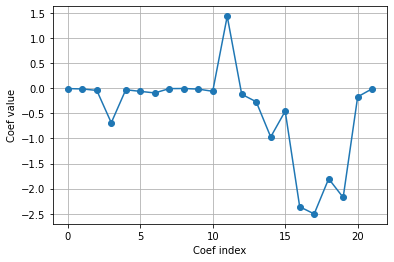

In [57]:
fig, ax = plt.subplots()
ax.plot(clf.coef_[0,:], '-o')
ax.set(xlabel='Coef index', ylabel='Coef value')
_ = ax.grid()

The model is mainly predicting that the features that are useful are 11 which is a payment in USD, as most transactions are in USD in the data. So this is not a good model. It is also giving some weight to the variables from 16 to 19 which is the type of payment, but as all are being weighted negatively it means that the transaction type not included ACH is being identified as highly correlated with ML. This as well is mostly identifying some high risk products to monitor in this case ACH, which is a helpful insight, but it is not sofisticated in how to do it.

In [58]:
corrs = list()
for col in range(X.shape[1]):
    corr = np.corrcoef(X[train_mask,col], y_txn[train_mask])[0,1]
    corrs.append(corr)
corrs = np.array(corrs)

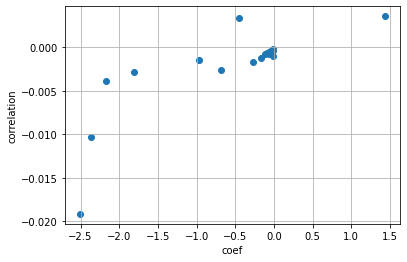

In [59]:
fig, ax = plt.subplots()
ax.scatter(x=clf.coef_[0,:], y=corrs)
ax.set(xlabel='coef', ylabel='correlation')
_ = ax.grid()

In [60]:
np.flip(np.argsort(np.nan_to_num(corrs, nan=-2)))

array([11, 15,  8,  7,  0,  1,  9,  4,  5,  2,  6, 10, 12, 21, 20, 14, 13,
        3, 18, 19, 16, 17])

In [61]:
X[y_txn==0,20]

array([ 2.33653518e-04, -2.66159398e-04, -2.17546887e-04, ...,
       -9.70976870e-06, -2.71195431e-04, -1.02784082e-04])

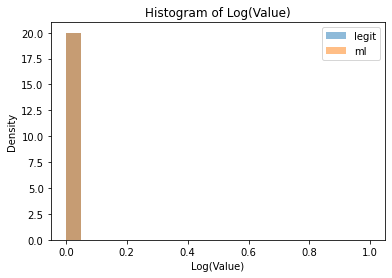

In [62]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(X[y_txn==0,21], bins=20, label='legit', density=True, alpha=0.5)
_ = ax.hist(X[y_txn==1,21], bins=bins, label='ml', density=True, alpha=0.5)
ax.legend()
_ = ax.set(xlabel='amount)', ylabel='Density', title='Histogram of amount')

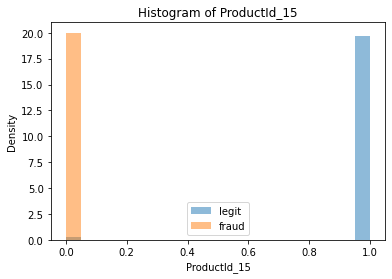

In [64]:
fig, ax = plt.subplots()
_, bins, _ = ax.hist(X[y_txn==0,11], bins=20, label='legit', density=True, alpha=0.5)
_ = ax.hist(X[y_txn==1,10], bins=bins, label='fraud', density=True, alpha=0.5)
ax.legend()
_ = ax.set(xlabel='ProductId_15', ylabel='Density', title='Histogram of ProductId_15')

In [122]:
rf = RandomForestClassifier(n_estimators=300)
rf.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_rf = rf.predict_proba(X[val_mask,:])
y_val_rf = rf.predict(X[val_mask,:])

y_hat_test_rf = rf.predict_proba(X[test_mask,:])
y_test_rf = rf.predict(X[test_mask,:])
rf

RandomForestClassifier(n_estimators=300)

In [66]:
clf_balanced = LogisticRegression(class_weight='balanced', max_iter=1000)
clf_balanced.fit(X[train_mask,:], y_txn[train_mask])

y_hat_val_lrb = clf_balanced.predict_proba(X[val_mask,:])
y_val_lrb = clf_balanced.predict(X[val_mask,:])

In [67]:
y_hat_test_lr = clf.predict_proba(X[test_mask,:])
y_test_lr = clf.predict(X[test_mask,:])

y_hat_test_lrb = clf_balanced.predict_proba(X[test_mask,:])
y_test_lrb = clf_balanced.predict(X[test_mask,:])

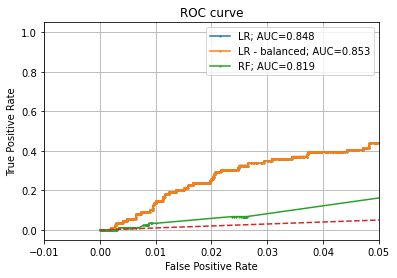

In [68]:
plot_roc(
    [y_txn[val_mask]]*3, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1]], 
    ['LR', 'LR - balanced', 'RF'],
    x_max=0.05,
)

/tmp/ipykernel_4202/4098154024.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/4098154024.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/4098154024.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)


LR
Best threshold:  0.0019432539762440145
Best F1-Score:  nan
LR - balanced
Best threshold:  0.7309840517996121
Best F1-Score:  nan
RF
Best threshold:  0.003489999810568182
Best F1-Score:  nan


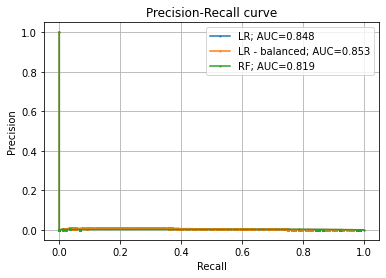

In [69]:
plot_pr(
    [y_txn[val_mask]]*3, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1]], 
    ['LR', 'LR - balanced', 'RF'],
)

In [70]:
X_fr = ml_rate_3hop.numpy()[:N_labels]
X_fr = (X_fr - X_fr.mean(axis=0))/(X_fr.max(axis=0) - X_fr.min(axis=0))
assert X_fr.shape[0] == N_labels

In [71]:
X_fr_full = np.zeros(X.shape[0])
X_fr_full[:N_labels] = X_fr
X.shape, X_fr_full.shape

((801050, 22), (801050,))

In [72]:
X_mod = np.hstack([X, X_fr_full.reshape((-1, 1))])
X.shape, X_mod.shape

((801050, 22), (801050, 23))

In [73]:
clf_fr = LogisticRegression()
clf_fr.fit(X_mod[train_mask,:], y_txn[train_mask])

y_hat_val_lr_fr = clf_fr.predict_proba(X_mod[val_mask,:])
y_val_lr_fr = clf_fr.predict(X_mod[val_mask,:])

y_hat_test_lr_fr = clf_fr.predict_proba(X_mod[test_mask,:])
y_test_lr_fr = clf_fr.predict(X_mod[test_mask,:])

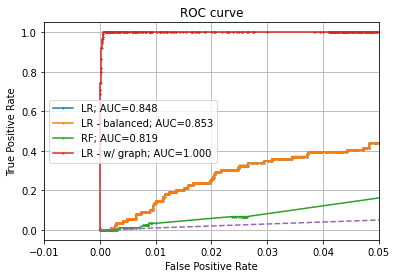

In [74]:
plot_roc(
    [y_txn[val_mask]]*4, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_hat_val_lr_fr[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LR - w/ graph'],
    x_max=0.05,
)

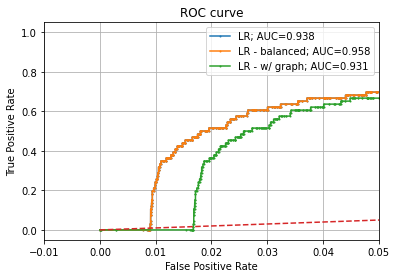

In [75]:
plot_roc(
    [y_txn[test_mask]]*4, 
    [y_hat_test_lr[:,1], y_hat_test_lrb[:,1], y_hat_test_lr_fr[:,1]], 
    ['LR', 'LR - balanced', 'LR - w/ graph'],
    x_max=0.05,
)

/tmp/ipykernel_4202/4098154024.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/4098154024.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/4098154024.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)


LR
Best threshold:  0.0019432539762440145
Best F1-Score:  nan
LR - balanced
Best threshold:  0.7309840517996121
Best F1-Score:  nan
RF
Best threshold:  0.003489999810568182
Best F1-Score:  nan
LR - w/ graph
Best threshold:  0.07641446958747176
Best F1-Score:  0.8078817733990148


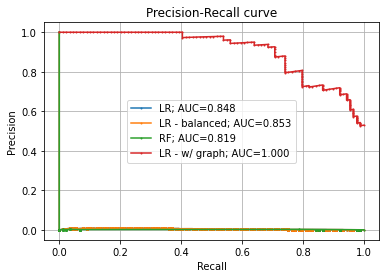

In [76]:
plot_pr(
    [y_txn[val_mask]]*4, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_hat_val_lr_fr[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LR - w/ graph'],
)

In [77]:
from scipy.sparse import diags

In [78]:
def label_propagation(g, baseline, train_mask, alpha=0.8, iters=20, warmup=10, dgl=False):
    labels = g.ndata['label']
    txn_idx = g.ndata['_TYPE']==g.ndata['_TYPE'].max().item() # the transaction nodes
    train_mask_g = th.zeros_like(labels).bool()
    train_mask_g[th.where(txn_idx)[0][train_mask]] = 1
    
    # Create (N_nodes, 2) label matrix, first col=legit prob, second col=fraud prob
    ## Init everything to baseline fraud rate
    s = th.zeros((labels.shape[0], 2))
    s[:,0] = 1 - baseline
    s[:,1] = baseline
    
    # overwrite training nodes
    s[(labels==0)&(train_mask_g),0] = 1
    s[(labels==0)&(train_mask_g),1] = 0
    
    s[(labels==1)&(train_mask_g),0] = 0
    s[(labels==1)&(train_mask_g),1] = 1
    
    
    assert (s.sum(dim=1)==1).float().mean()==1
    
    y_train = s.clone().detach()
    y_preds = list()
    
    
    if dgl:
        print('dgl')
        with g.local_scope():
            src, dst = g.edges()
            src_d = g.in_degrees(src).float()
            dst_d = g.in_degrees(dst).float()
            g.edata['w'] = 1/th.sqrt(dst_d) * 1/th.sqrt(src_d) # edge weight w = 1/sqrt(d_i*d_j)
            # Get node-level normalization of edge weights
            g.update_all(fn.copy_e('w', 'm'), fn.sum('m', 'w_total'))
            g.apply_edges(fn.e_div_v('w', 'w_total', 'w_norm')) # w_norm = w/sum(w)

            for e in range(iters):
                g.ndata['feat'] = s 
                g.update_all(
                    fn.u_mul_e('feat', 'w_norm', 'm'), 
                    fn.sum('m', 'h')
                )
                h = g.ndata['h']

                s = alpha*h + (1-alpha)*y_train

                if e >= warmup:
                    y_preds.append(s[th.where(txn_idx)[0]])
    
    
    else:
        print("no dgl")
        adj = g.adj(transpose=True, scipy_fmt='coo')
        d_inv_root = diags(np.sqrt(1/adj.sum(axis=1)).flatten().tolist()[0])
        a_scaled = d_inv_root @ adj @ d_inv_root
        norm = diags((1/a_scaled.sum(axis=1)).flatten().tolist()[0])
        w = (norm @ a_scaled).tocoo()
        w = th.sparse_coo_tensor(np.stack([w.row, w.col]), w.data).float()
        
        for e in range(iters):
            h = (w @ s)
            s = alpha*h + (1-alpha)*y_train
  
            if e >= warmup:
                y_preds.append(s[th.where(txn_idx)[0]])
        
    return y_preds

In [79]:
g = dgl.to_homogeneous(hg, ndata=['label'])

In [80]:
txnTypeIdx = g.ndata['_TYPE'].max().item()
assert th.equal(
    g.ndata['label'][g.ndata['_TYPE']==txnTypeIdx],
    th.tensor(np.nan_to_num(y_txn, nan=baseline)).float(),
)

assert np.array_equal(
    g.ndata['label'][g.ndata['_TYPE']==txnTypeIdx][train_mask].numpy(), 
    y_txn[train_mask]
)

In [81]:
y_lps = label_propagation(g, baseline, train_mask, alpha=0.5, iters=20, warmup=10, dgl=True)

dgl


In [82]:

y_test_lp = y_lps[-1][test_mask,:]

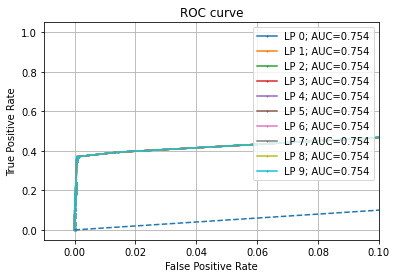

In [83]:
# DGL
plot_roc(
    [y_txn[val_mask]]*len(y_lps), 
    [y[val_mask,1] for y in y_lps], 
    [f'LP {i}' for i in range(len(y_lps))],
    x_max=0.1,
)

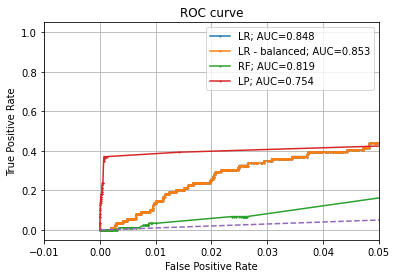

In [84]:
plot_roc(
    [y_txn[val_mask]]*4, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1]], 
    ['LR', 'LR - balanced', 'RF', 'LP'],
    x_max=0.05,
)

/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)


LR
Best threshold:  0.0019432539762440145
Best F1-Score:  nan
LR - balanced
Best threshold:  0.7309840517996121
Best F1-Score:  nan
RF
Best threshold:  0.003571790156118078
Best F1-Score:  nan
LP
Best threshold:  0.0036928053
Best F1-Score:  0.3013698630136986


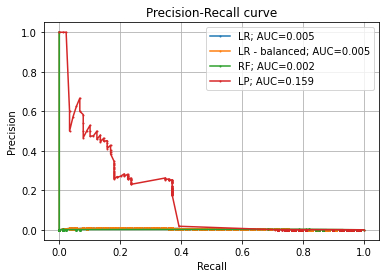

In [209]:
plot_pr(
    [y_txn[val_mask]]*5, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_lps[-1][val_mask,1]], 
    ['LR', 'LR - balanced', 'RF', 'LP'],
)

/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)


LR
Best threshold:  0.0019432541042265891
Best F1-Score:  nan
LR - balanced
Best threshold:  0.7309857367687455
Best F1-Score:  nan
RF
Best threshold:  0.0019656223866115863
Best F1-Score:  nan
LP
Best threshold:  0.08825412
Best F1-Score:  nan


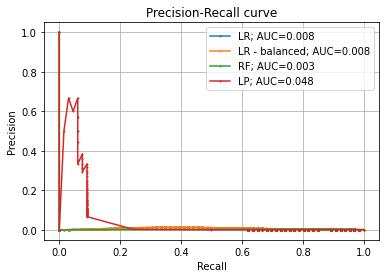

In [205]:
plot_pr(
    [y_txn[test_mask]]*4, 
    [y_hat_test_lr[:,1], y_hat_test_lrb[:,1], y_hat_test_rf[:,1], y_lps[-1][test_mask,1]], 
    ['LR', 'LR - balanced', 'RF', 'LP'],
)

GNN

In [86]:
from dgl.nn import GraphConv, HeteroGraphConv, WeightBasis

In [87]:
def plot_losses(train_losses, val_losses, log=False):
    """
    Plots train/validation loss curves vs training epoch
    """
    fig, ax = plt.subplots()

    ax.plot(train_losses, label='Train')
    ax.plot(val_losses, label='Val')
    ax.set(xlabel='Epoch', ylabel='CrossEnt')
    if log:
        ax.set_yscale('log')
    ax.legend()
    ax.grid()
    
@th.no_grad()
def infer(model_cp, hg, mask, best_model_fp=None):
    if best_model_fp:
        print("loading from disk")
        model = deepcopy(model_cp)
        model.load_state_dict(th.load(best_model_fp))
    else:
        model = model_cp
        
    model.to(device)
    
    model.eval()
    
    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = NodeDataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)
    
    y_preds = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        y_preds.append(logits.softmax(dim=1))
        
    return th.cat(y_preds).cpu()
    
@th.no_grad()
def test(model, hg, mask, best_path=None):

    model.eval()
    
    features = hg.ndata['feat']

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = NodeDataLoader(
        hg, {'txnIdx': th.where(mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)

    labels = hg.ndata['label']['txnIdx'].long()
    

    correct = list()
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        y_preds = logits.argmax(1)
        n_correct = (labels[output_nodes['txnIdx']]==y_preds).sum().item()
        correct.append((labels[output_nodes['txnIdx']]==y_preds).sum().item())


    acc = sum(correct)/(th.where(mask)[0].shape[0])

    return acc

def train_step(model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight=False):
    """
    A single training step
    """
    model.train()
    optimizer.zero_grad()

    sampler = dgl.dataloading.MultiLayerNeighborSampler([15]*len(model.convs))
    dataloader = NodeDataLoader(
        hg, {'txnIdx': th.where(train_mask)[0]}, sampler,
        batch_size=1024, shuffle=True, drop_last=False, num_workers=0)
    
    val_loader = NodeDataLoader(
        hg, {'txnIdx': th.where(val_mask)[0]}, sampler,
        batch_size=1024, shuffle=False, drop_last=False, num_workers=0)
    
    train_losses = list()
    if weight:
        weight = th.tensor([1., 1/baseline]).float().to(device)
    else:
        weight = None
        
    labels = hg.ndata['label']['txnIdx'].long()
    
    for input_nodes, output_nodes, blocks in dataloader:
        h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
        blocks = [b.to(device) for b in blocks]
        
        logits = model(blocks, h)
        loss = loss_fn(logits, labels[output_nodes['txnIdx']], weight=weight)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        train_losses.append(loss.item())
    

    val_losses = list()
    with th.no_grad():
        for input_nodes, output_nodes, blocks in val_loader:
            h = {k: features[k][input_nodes[k]].to(device) for k in input_nodes.keys()}
            blocks = [b.to(device) for b in blocks]
            
            logits = model(blocks, h)
            val_loss = loss_fn(logits, labels[output_nodes['txnIdx']])
            val_losses.append(val_loss.item())

    return np.array(train_losses).mean(), np.array(val_losses).mean()

def train(hg, split_idx, model, epochs, evaluator, 
          device, save_path, loss_fn=F.cross_entropy, lr=0.01, 
          es_criteria=5, weight_class=False, verbose=False):
    optimizer = optim.Adam(model.parameters(), lr=lr)
    best_val_metric = 1e10
    train_losses = list()
    val_losses = list()

    features = hg.ndata['feat']
  
    train_mask = split_idx['train'].to(device)
    val_mask = split_idx['valid'].to(device)
    es_iters = 0
    
    for e in range(1, epochs+1):
        
        # print("Training step")
        train_loss, val_loss = train_step(
            model, hg, features, train_mask, val_mask, optimizer, loss_fn, weight_class,
        )
        train_losses.append(train_loss)
        val_losses.append(val_loss)

        # Compute accuracy on training/validation/test
        # print("Train eval")
        train_acc = test(model, hg, train_mask)
        # print("Val eval")
        val_acc = test(model, hg, val_mask)
        
        val_metric = val_loss
        
        if val_metric > 1e5:
            print(f"Early stopping for huge loss: {val_metric}")
            break

        # Save the best validation accuracy and the corresponding test accuracy.
        if val_metric < best_val_metric  :
            best_val_metric = val_metric
            th.save(model.state_dict(), save_path)
            es_iters = 0
        else:
            es_iters += 1
            

        if e % 5 == 0 and verbose:
#             for name, param in model.named_parameters():
#                 print(name, param.grad.max(), param.grad.min())
            
            print('In epoch {}, loss: {:.3f}, val metric: {:.3f} (best {:.3f})'.format(
                e, train_loss, val_metric, best_val_metric))
            
        if es_iters >= es_criteria:
            print(f"Early stopping at {e} epochs")
            break
            
    return np.array(train_losses), np.array(val_losses)

In [88]:
class RelGraphConvLayer(nn.Module):
    # from https://github.com/dmlc/dgl/blob/master/examples/pytorch/rgcn-hetero/model.py
    r"""Relational graph convolution layer.
    Parameters
    ----------
    in_feat : int
        Input feature size.
    out_feat : int
        Output feature size.
    rel_names : list[str]
        Relation names.
    num_bases : int, optional
        Number of bases. If is none, use number of relations. Default: None.
    weight : bool, optional
        True if a linear layer is applied after message passing. Default: True
    bias : bool, optional
        True if bias is added. Default: True
    activation : callable, optional
        Activation function. Default: None
    self_loop : bool, optional
        True to include self loop message. Default: False
    dropout : float, optional
        Dropout rate. Default: 0.0
    """
    def __init__(self,
                 in_feat,
                 out_feat,
                 rel_names,
                 *,
                 num_bases=None,
                 weight=True,
                 bias=True,
                 activation=None,
                 self_loop=False,
                 bn=False,
                 dropout=0.0):
        super(RelGraphConvLayer, self).__init__()
        self.in_feat = in_feat
        self.out_feat = out_feat
        self.rel_names = rel_names
        self.num_bases = num_bases
        self.bias = bias
        self.activation = activation
        self.self_loop = self_loop
        self.bn = bn

        self.conv = HeteroGraphConv({
                rel : GraphConv(in_feat, out_feat, norm='right', weight=False, bias=False)
                for rel in rel_names
            })

        self.use_weight = weight
        self.use_basis = num_bases is not None and num_bases < len(self.rel_names) and weight
        if self.use_weight:
            if self.use_basis:
                self.basis = WeightBasis((in_feat, out_feat), num_bases, len(self.rel_names))
            else:
                self.weight = nn.Parameter(th.Tensor(len(self.rel_names), in_feat, out_feat))
                nn.init.xavier_uniform_(self.weight, gain=nn.init.calculate_gain('relu'))

        # bias
        if bias:
            self.h_bias = nn.Parameter(th.Tensor(out_feat))
            nn.init.zeros_(self.h_bias)

        # weight for self loop
        if self.self_loop:
            self.loop_weight = nn.Parameter(th.Tensor(in_feat, out_feat))
            nn.init.xavier_uniform_(self.loop_weight,
                                    gain=nn.init.calculate_gain('relu'))
            
        if self.bn:
            self.bn_layer = nn.BatchNorm1d(out_feat)

        self.dropout = nn.Dropout(dropout)

    def forward(self, g, inputs):
        """Forward computation
        Parameters
        ----------
        g : DGLHeteroGraph
            Input graph.
        inputs : dict[str, torch.Tensor]
            Node feature for each node type.
        Returns
        -------
        dict[str, torch.Tensor]
            New node features for each node type.
        """
        g = g.local_var()
        if self.use_weight:
            weight = self.basis() if self.use_basis else self.weight
            wdict = {self.rel_names[i] : {'weight' : w.squeeze(0)}
                     for i, w in enumerate(th.split(weight, 1, dim=0))}
        else:
            wdict = {}

        if g.is_block:
            inputs_src = inputs
            inputs_dst = {k: v[:g.number_of_dst_nodes(k)] for k, v in inputs.items()}
        else:
            inputs_src = inputs_dst = inputs

        hs = self.conv(g, inputs, mod_kwargs=wdict)

        def _apply(ntype, h):
            if self.self_loop:
                h = h + th.matmul(inputs_dst[ntype], self.loop_weight)
            if self.bias:
                h = h + self.h_bias
            if self.bn:
                h = self.bn_layer(h)
            if self.activation:
                h = self.activation(h)
            return self.dropout(h)
        return {ntype : _apply(ntype, h) for ntype, h in hs.items()}

In [89]:
class RGCN(nn.Module):
    def __init__(self, hg, in_feats, h_feats, num_classes, num_layers, num_bases, 
                 self_loop=True, dropout=0, bn=False):

        super(RGCN, self).__init__()
        self.dropout = dropout
        
        # GNN layers
        self.convs = nn.ModuleList()
        activation_fn = nn.ReLU()
        self.convs.append(RelGraphConvLayer(
            in_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout, 
            num_bases=num_bases, self_loop=self_loop, bn=bn))

        for _ in range(num_layers-1):
            self.convs.append(RelGraphConvLayer(
                h_feats, h_feats, hg.etypes, activation=activation_fn, dropout=dropout, 
                num_bases=num_bases, self_loop=self_loop, bn=bn
            ))
        
        # Output linear layer
        self.output_layer = nn.Linear(h_feats+in_feats, num_classes)

    def forward(self, blocks, in_feat):
        """
        The forward pass of the model, which applies all of the layers
        to a given graph and set of node features
        
        Args:
            g (DGLGraph): the graph used for Graph Convolutions
            in_feat (Tensor): the node features
        """
        h = in_feat
        for i, conv in enumerate(self.convs):
            h = conv(blocks[i], h)

        h_in = blocks[-1].dstdata['feat']['txnIdx']
        h = self.output_layer(th.cat([h['txnIdx'], h_in], dim=1))
        return h

    
class LabelSmoothing(nn.Module):
    """NLL loss with label smoothing.
    """
    def __init__(self, smoothing=0.0):
        """Constructor for the LabelSmoothing module.
        :param smoothing: label smoothing factor
        """
        super(LabelSmoothing, self).__init__()
        self.confidence = 1.0 - smoothing
        self.smoothing = smoothing

    def forward(self, x, target, weight=None):
        logprobs = nn.functional.log_softmax(x, dim=-1)
        nll_loss = -logprobs.gather(dim=-1, index=target.unsqueeze(1))
        nll_loss = nll_loss.squeeze(1)
        smooth_loss = -logprobs.mean(dim=-1)
        loss = self.confidence * nll_loss + self.smoothing * smooth_loss
        return loss.mean()

In [98]:
hg.num_nodes(ntype)

1042909

In [134]:
for ntype in hg.ntypes:
    if ntype=='txnIdx':
        X_tmp = th.tensor(X).float() # the natural features
    else:
        # random values as features
        X_rand = th.zeros((hg.num_nodes(ntype), X.shape[1]-1))
        #X_rand = th.rand((hg.num_nodes(ntype), X.shape[1]-1))-0.5

        print(ntype, hg.num_nodes(ntype))
        in_degrees = th.zeros(hg.num_nodes(ntype))
        for cetype in hg.canonical_etypes:
            if ntype==cetype[2]:
                print(cetype)
                in_degrees += hg.in_degrees(etype=cetype)
        in_degrees = th.log(in_degrees+1).reshape((-1, 1))
        in_degrees -= in_degrees.mean()

        X_tmp = th.hstack([X_rand, in_degrees])
    hg.nodes[ntype].data['feat'] = X_tmp

acct1Idx 1042909
('acct2Idx', 'acct2Idx-acct1Idx', 'acct1Idx')
('txnIdx', 'txnIdx-acct1Idx', 'acct1Idx')
acct2Idx 1042910
('acct1Idx', 'acct1Idx-acct2Idx', 'acct2Idx')
('txnIdx', 'txnIdx-acct2Idx', 'acct2Idx')


In [135]:
split_mask = {
    'train': th.tensor(train_mask),
    'valid': th.tensor(val_mask),
    'test': th.tensor(test_mask)
}

In [136]:
oss_fn = LabelSmoothing(smoothing=0.1)

In [137]:
model_kwargs = dict(
    in_feats=X.shape[1], h_feats=256, num_classes=2, 
    num_layers=2, dropout=0.1, num_bases=None,
    self_loop=False, bn=True,
)
model = RGCN(hg, **model_kwargs).to(device)
model

RGCN(
  (convs): ModuleList(
    (0): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (acct1Idx-acct2Idx): GraphConv(in=22, out=256, normalization=right, activation=None)
          (acct1Idx-txnIdx): GraphConv(in=22, out=256, normalization=right, activation=None)
          (acct2Idx-acct1Idx): GraphConv(in=22, out=256, normalization=right, activation=None)
          (acct2Idx-txnIdx): GraphConv(in=22, out=256, normalization=right, activation=None)
          (txnIdx-acct1Idx): GraphConv(in=22, out=256, normalization=right, activation=None)
          (txnIdx-acct2Idx): GraphConv(in=22, out=256, normalization=right, activation=None)
        )
      )
      (bn_layer): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (1): RelGraphConvLayer(
      (activation): ReLU()
      (conv): HeteroGraphConv(
        (mods): ModuleDict(
          (

In [138]:
loss_fn = LabelSmoothing(smoothing=0.1)

In [139]:
hg.ndata['label']['txnIdx']

tensor([0., 0., 0.,  ..., 0., 0., 0.])

In [140]:
hg.ndata

defaultdict(<class 'dict'>, {'label': {'acct1Idx': tensor([0.0007, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007]), 'acct2Idx': tensor([0.0007, 0.0007, 0.0007,  ..., 0.0007, 0.0007, 0.0007]), 'txnIdx': tensor([0., 0., 0.,  ..., 0., 0., 0.])}, 'feat': {'acct1Idx': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  5.0290],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.7108],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.7108],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.3878],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.3878],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.3878]]), 'acct2Idx': tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  3.8722],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  4.0220],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  4.0044],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000, -0.7229

In [180]:
train_losses, val_losses = train(
    hg.to(device), split_mask, model.to(device), 200, None, 
    device, 'models/rgcn.pt', loss_fn=loss_fn, lr=0.001, 
    es_criteria=50, verbose=True, weight_class=True,
)

/opt/conda/envs/ibmaml/lib/python3.8/site-packages/torch/nn/modules/module.py:1383: UserWarning: positional arguments and argument "destination" are deprecated. nn.Module.state_dict will not accept them in the future. Refer to https://pytorch.org/docs/master/generated/torch.nn.Module.html#torch.nn.Module.state_dict for details.
  warnings.warn(


In epoch 5, loss: 0.201, val metric: 0.201 (best 0.201)
In epoch 10, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 15, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 20, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 25, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 30, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 35, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 40, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 45, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 50, loss: 0.202, val metric: 0.202 (best 0.201)
In epoch 55, loss: 0.202, val metric: 0.202 (best 0.201)
Early stopping at 57 epochs


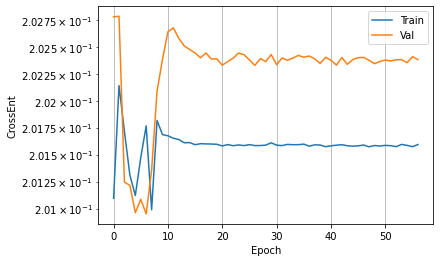

In [181]:
plot_losses(train_losses, val_losses, log=True)

In [182]:
y_val_hat_rgcn = infer(model.to(device), hg.to(device), split_mask['valid'].to(device), 'models/rgcn.pt')
y_test_hat_rgcn = infer(model.to(device), hg.to(device), split_mask['test'].to(device), 'models/rgcn.pt')

loading from disk
loading from disk


/tmp/ipykernel_4202/4242417624.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/4242417624.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/4242417624.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)


[0.00093406 0.00091992 0.00091992 ...        nan        nan 0.        ]
LR
Best threshold:  0.0019432541042265891
Best F1-Score:  nan
[0.00304302 0.00299698 0.00299705 ...        nan        nan 0.        ]
LR - balanced
Best threshold:  0.7309857367687455
Best F1-Score:  nan
[0.00325934 0.00512225 0.00512246 0.00512266 0.00513974 0.00514015
 0.00514614 0.00514635 0.00514656 0.00514738 0.00515008 0.00515028
 0.00515091 0.00515505 0.00515672 0.00515692 0.00515921 0.00515942
 0.00516046 0.00516233 0.00516254 0.00516358 0.00517527 0.00517841
 0.00518009 0.00522065 0.00522342 0.00522577 0.0052279  0.00522833
 0.00522854 0.00526164 0.00526359 0.00526381 0.00526792 0.00526944
 0.00526966 0.00527009 0.00527053 0.00527118 0.00527205 0.00527422
 0.00527465 0.00527596 0.00527639 0.00527683 0.00527704 0.00527748
 0.00527813 0.00527835 0.00528423 0.00528445 0.00528554 0.00528576
 0.0052862  0.00528663 0.00528685 0.00528729 0.00528751 0.00529297
 0.00530262 0.00530284 0.00530768 0.005309   0.0053134

/tmp/ipykernel_4202/4242417624.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/4242417624.py:25: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)


[0.00089745 0.00088386 0.00088387 ... 0.02941176        nan 0.        ]
LP
Best threshold:  0.08825412
Best F1-Score:  nan
[0.00324907 0.00323062 0.003257   ...        nan        nan 0.        ]
RGCN
Best threshold:  0.057323158
Best F1-Score:  nan


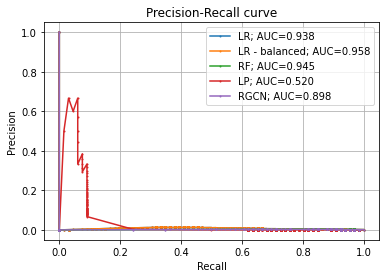

In [191]:
plot_pr(
    [y_txn[test_mask]]*5, 
    [y_hat_test_lr[:,1], y_hat_test_lrb[:,1], y_hat_test_rf[:,1], y_lps[-1][test_mask,1], y_test_hat_rgcn[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LP', 'RGCN'],
)

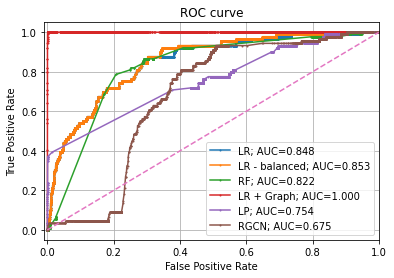

In [184]:
plot_roc(
    [y_txn[val_mask]]*6, 
    [y_hat_val_lr[:,1], y_hat_val_lrb[:,1], y_hat_val_rf[:,1], y_hat_val_lr_fr[:,1], y_lps[-1][val_mask,1], y_val_hat_rgcn[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LR + Graph', 'LP', 'RGCN'],
    x_max=1,
)

/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)
/tmp/ipykernel_4202/2868876587.py:27: RuntimeWarning: invalid value encountered in true_divide
  f1_scores = 2*re*pr/(re+pr)


LR
Best threshold:  0.0019432541042265891
Best F1-Score:  nan
LR - balanced
Best threshold:  0.7309857367687455
Best F1-Score:  nan
RF
Best threshold:  0.0019656223866115863
Best F1-Score:  nan
LR + Graph
Best threshold:  0.00020826184037135375
Best F1-Score:  nan
LP
Best threshold:  0.08825412
Best F1-Score:  nan
RGCN
Best threshold:  0.057323158
Best F1-Score:  nan


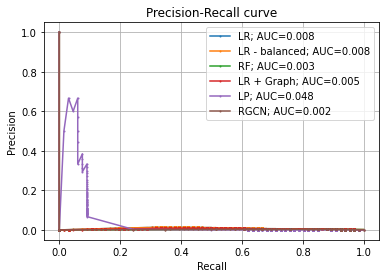

In [207]:
plot_pr(
    [y_txn[test_mask]]*6, 
    [y_hat_test_lr[:,1], y_hat_test_lrb[:,1], y_hat_test_rf[:,1], y_hat_test_lr_fr[:,1], y_lps[-1][test_mask,1], y_test_hat_rgcn[:,1]], 
    ['LR', 'LR - balanced', 'RF', 'LR + Graph', 'LP', 'RGCN'],
)

In [186]:
y_test_hat_rgcn = infer(
    model.to(device), hg.to(device), split_mask['test'].to(device), 'models/rgcn.pt'
)

loading from disk


In [187]:
y_test_hat_rgcn

tensor([[0.9496, 0.0504],
        [0.9327, 0.0673],
        [0.9496, 0.0504],
        ...,
        [0.9427, 0.0573],
        [0.9427, 0.0573],
        [0.9427, 0.0573]])